In [2]:
from extract import SocialETL, construct_query_for_twarc, extract_tags, SocialDB, UserETL
from extract import CategorizeUsers
import hashtags as h
import hashtags_readcsv as r_csv
import pandas as pd
import numpy as np
import json
import networkx as nx
from numpy import nan

# 1) Download DF

In [3]:
m1 = SocialETL(query="(#slavaukraini OR #stopwarinukraine OR #istandwithputin)", pages=1000, recent=False) 

Reading secret from C:\Users\david\Documents\GitHub\ds-network-analysis\data\my_secrets.yaml…

Output()

In [4]:
m1.df=m1.df.dropna(subset=['entities.hashtags'])
m1.df=m1.df.dropna(subset=['retweeted_user_id'])

In [5]:
m1.df['entities.hashtags']=m1.df['entities.hashtags'].apply(eval)
m1.df['entities.hashtags']=m1.df['entities.hashtags'].map(h.extract_tags)

In [6]:
df_nodes=pd.DataFrame({"user_id":m1.df['author_id'],
                       'tweet_id':m1.df['id'],
                      'retweet_id': m1.df['retweeted_user_id'],
                      "hashtag":m1.df['entities.hashtags'],
                     'location':m1.df['author.location'],
                     'verified':m1.df['author.verified']
                      })

In [7]:
#df_proukr.set_index('user_id',inplace=True)
df_nodes.shape

(47853, 6)

In [8]:
df_nodes.to_csv('df_nodes')

## preprocessing 

In [37]:
df_nodes=pd.read_csv('df_nodes')
del df_nodes['Unnamed: 0']

In [9]:
df_nodes=df_nodes.set_index('user_id') #,inplace=True)

In [10]:
df_nodes

,tweet_id,retweet_id,hashtag,location,verified
user_id,,,,,
1007449601400541184,1503521257177948170,278369814,"[putin, slavaukraini]","Mobile, AL",False
1464582321533767695,1503521249850363904,291496884,"[stopputin, stopwar, stopwarinukraine]",NaN,False
1245946724994158592,1503521066739589120,3312966191,"[standwithukraine, stopputinnow, slavaukraini]",NaN,False
854862661,1503521023450361861,465973,[slavaukraini],NaN,False
42746752,1503520988297932802,1456400208431091712,"[dogsoftwittter, dogsoftwitter, stoprussia, st...","Northeast Ohio, USA",False
...,...,...,...,...,...
396145409,1501662088846061577,191393940,"[slavaukraini, standwithukraine]","West Midlands, England",False
1486393266782314498,1501662072094048266,279390084,"[fckptn, slavaukraini]",NaN,False
1390353643,1501662038195638272,1192160073897988096,"[standwithukraine, istandwithukraine, slavaukr...",County Cork,False


In [11]:
df_nodes.index=df_nodes.index.map(int)
df_nodes['hashtag']=df_nodes['hashtag'].map(str).apply(eval)
df_nodes['tweet_id']=df_nodes['tweet_id'].map(str).apply(eval)
df_nodes['retweet_id']=df_nodes['retweet_id'].map(str).apply(eval)
df_nodes['location']=df_nodes['location'].map(str)#.apply(eval)
df_nodes['verified']=df_nodes['verified'].map(str).apply(eval)

In [12]:
df_nodes.shape

(47853, 5)

In [13]:
df_nodes.head(3)

,tweet_id,retweet_id,hashtag,location,verified
user_id,,,,,
1007449601400541184,1503521257177948170,278369814,"[putin, slavaukraini]","Mobile, AL",False
1464582321533767695,1503521249850363904,291496884,"[stopputin, stopwar, stopwarinukraine]",nan,False
1245946724994158592,1503521066739589120,3312966191,"[standwithukraine, stopputinnow, slavaukraini]",nan,False


In [14]:
#convert nested lists on set
def to_sets(nested_lists): 
    outer_list = set()
    for el in nested_lists: 
        if type(el) == list: 
            outer_list.update(el) 
        else: 
            outer_list.add(el)
    return outer_list
df_nodes['hashtag']=df_nodes['hashtag'].map(to_sets)

In [15]:
df_nodes.head(3)

,tweet_id,retweet_id,hashtag,location,verified
user_id,,,,,
1007449601400541184,1503521257177948170,278369814,"{slavaukraini, putin}","Mobile, AL",False
1464582321533767695,1503521249850363904,291496884,"{stopwarinukraine, stopputin, stopwar}",nan,False
1245946724994158592,1503521066739589120,3312966191,"{slavaukraini, stopputinnow, standwithukraine}",nan,False


# 2) Categorizzazione utenti

In [61]:
set_user=set(df_nodes.index)
print(len(set_user))

22252


In [ ]:
cat = CategorizeUsers(set_user, pages=1) #max_results=100 from 15-2 to 15-3

In [ ]:
print(cat)

In [ ]:
with open('output_cat.txt','w') as f:
    f.write(cat.users)

In [ ]:
c_proukr = 0
c_pax = 0
c_nocare = 0
c_prorus= 0

for v in cat.users.values():
    if v == "proukr":
        c_proukr + 1 
    elif v == "pax":
        c_pax + = 1
    elif v == "prorus":
        c_prorus + = 1
    else:
        c_nocare + = 1

print('TOT USERS = {} \ n'
      'proukr = {} \ n'
      'pax = {} \n'
      'prorus = {} \n'
      'nocare = {} \n'.format(len(cat.users),c_proukr,c_pax, c_prorus, c_nocare))

In [ ]:
user_node=[]
user_cat=[]
for k,v in cat.users.items():
    user_node.append(k)
    user_cat.append(v)

In [ ]:
df_cat=pd.DataFrame({'user_id':user_node,
                     'cat': user_cat})
df_cat=df_cat.set_index('user_id')

In [ ]:
#copy of the dataset with distinct index
#copy because duplicates need to accounted to assign weights
df_nodes_copy = df_nodes[~df_nodes.index.duplicated(keep='first')]
df_final=pd.concat(objs=[df_nodes_copy,df_cat], axis=1)

In [23]:
df_final = df_nodes[~df_nodes.index.duplicated(keep='first')]

In [24]:
df_final.shape

(32382, 5)

In [ ]:
df_final.to_csv('df_final')

# 3 Creazione rete

In [28]:
G = nx.Graph()

In [29]:
for i,e in df_final.iterrows():
    G.add_node(i)#, category=df_final['cat'][i], verified=df_final['verified'][i], location=df_final['location'][i])

In [ ]:
#list(G.nodes.data())

In [16]:
#PRIMA DATASET-->POI DIZIONARIO--->POI COLLEGARE LINK CON NODI + PESI
from_u=[]
to_u=[]
for u, user in enumerate(df_nodes.index):
    #print('u',user, type(user))
    for r,ret in enumerate(df_nodes['retweet_id']):
        #print('ret',ret, type(ret))
        if user==ret and user!=df_nodes.index[r]:
                from_u.append(user)
                to_u.append(df_nodes.index[r])

In [17]:
df=pd.DataFrame({'from':from_u,
                'to':to_u})
df.shape

(224286, 2)

In [18]:
df_weighted = df.value_counts().to_frame("weights").reset_index()
df_weighted.shape

(12816, 3)

In [19]:
df_weighted["weights"] = (df_weighted["weights"] - (df_weighted["weights"]).min())/((df_weighted["weights"].max()-(df_weighted["weights"]).min()))
df_weighted.head(3)

,from,to,weights
0,2202063265,1081484761934319623,1.000000
1,1380145054644379652,1402929890442285056,0.568343
2,820731335157383170,200080261,0.545132


In [20]:
df_weighted.shape

(12816, 3)

In [22]:
df_weighted.to_csv('df_weighted')

In [30]:
for i,e in df_weighted.iterrows():
    G.add_edge(df_weighted['from'][i],df_weighted['to'][i], w=df_weighted['weights'][i] )

In [31]:
G.remove_edges_from(list(nx.selfloop_edges(G)))
G.remove_nodes_from(list(nx.isolates(G)))

In [28]:
list(G.edges.data())

[(805741063, 700071853, {'w': 0.0}),
 (1298987457908633602, 2956836471, {'w': 0.05563480741797432}),
 (739256153100722176, 1155593244606160897, {'w': 0.0014265335235378032}),
 (739256153100722176, 110228223, {'w': 0.0014265335235378032}),
 (1317625832492441600, 28092030, {'w': 0.0}),
 (175604092, 1307865457903448064, {'w': 0.0014265335235378032}),
 (825118870931333124, 722431116, {'w': 0.0}),
 (1080666845282213890, 1270133776748855304, {'w': 0.009985734664764621}),
 (1080666845282213890, 760694335356690432, {'w': 0.005706134094151213}),
 (1080666845282213890, 49175397, {'w': 0.0028530670470756064}),
 (1080666845282213890, 2460279166, {'w': 0.0014265335235378032}),
 (1080666845282213890, 1142623492141211650, {'w': 0.0014265335235378032}),
 (1080666845282213890, 468851612, {'w': 0.0}),
 (2616411822, 443369826, {'w': 0.024251069900142655}),
 (827333887, 815708250217840640, {'w': 0.0014265335235378032}),
 (1323090359581200385, 444260943, {'w': 0.0014265335235378032}),
 (1199553378, 2749388

number of nodes = 11197 , number of edges = 12767 . number of components = 225


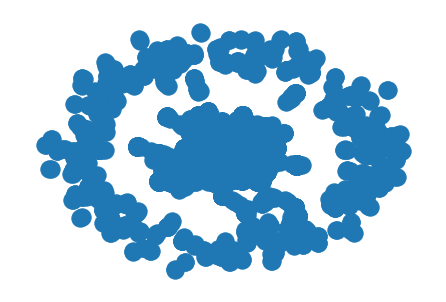

In [32]:
c=0
for component in list(nx.connected_components(G)):
    c += 1
nx.draw(G)
print('number of nodes =',G.number_of_nodes(),', number of edges =', G.number_of_edges(),'. number of components =',c) 

In [34]:
nx.write_gexf(G,'first_net.gexf')
#nx.write_gexf(G,'net_50')

In [33]:
[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]

[10184,
 37,
 33,
 28,
 26,
 21,
 19,
 18,
 18,
 16,
 16,
 14,
 14,
 14,
 13,
 13,
 12,
 12,
 11,
 10,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [35]:
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
print(len(S))

225


In [36]:
for e in S:
    print(e)

Graph with 10184 nodes and 11968 edges
Graph with 26 nodes and 25 edges
Graph with 5 nodes and 4 edges
Graph with 5 nodes and 4 edges
Graph with 2 nodes and 1 edges
Graph with 2 nodes and 1 edges
Graph with 4 nodes and 3 edges
Graph with 2 nodes and 1 edges
Graph with 8 nodes and 7 edges
Graph with 2 nodes and 1 edges
Graph with 28 nodes and 27 edges
Graph with 37 nodes and 40 edges
Graph with 11 nodes and 10 edges
Graph with 3 nodes and 2 edges
Graph with 5 nodes and 4 edges
Graph with 2 nodes and 1 edges
Graph with 14 nodes and 13 edges
Graph with 18 nodes and 17 edges
Graph with 6 nodes and 5 edges
Graph with 9 nodes and 8 edges
Graph with 2 nodes and 1 edges
Graph with 7 nodes and 6 edges
Graph with 2 nodes and 1 edges
Graph with 3 nodes and 2 edges
Graph with 9 nodes and 8 edges
Graph with 2 nodes and 1 edges
Graph with 2 nodes and 1 edges
Graph with 4 nodes and 3 edges
Graph with 2 nodes and 1 edges
Graph with 2 nodes and 1 edges
Graph with 2 nodes and 1 edges
Graph with 6 nodes 

In [62]:
for i,e in enumerate(S):
    print('component',i)
    print(list(e.nodes.data()))

component 0
[(1040405782402084864, {}), (1499201862456778753, {}), (1487155820475437056, {}), (1310241004004544513, {}), (1426123212220424193, {}), (1477297439099039749, {}), (969202095252561920, {}), (805741063, {}), (1440664285210767367, {}), (3011246728, {}), (1492196594434940937, {}), (1475481499415846921, {}), (43173254, {}), (89319056, {}), (196607761, {}), (1244372887, {}), (52761753, {}), (20478618, {}), (262267551, {}), (1206533161, {}), (31949738, {}), (559023147, {}), (700071853, {}), (298289585, {}), (742538359659212800, {}), (259326782, {}), (1723891909, {}), (16493125, {}), (792139214, {}), (578590553, {}), (24516826, {}), (1014532957, {}), (757342316, {}), (2975160689, {}), (229289841, {}), (276093811, {}), (280064371, {}), (291878014, {})]
component 1
[(1298987457908633602, {}), (268854656, {}), (825118870931333124, {}), (1080666845282213890, {}), (2616411822, {}), (827333887, {}), (386819593, {}), (770046663926902784, {}), (1148408072, {}), (1199553378, {}), (291671270

In [ ]:
#remove small component
th=40
for component in list(nx.connected_components(G)):
    c += 1
    if len(component)<th:
        for node in component:
            G.remove_node(node)

number of nodes = 1926 , number of edges = 2279 . number of components = 5


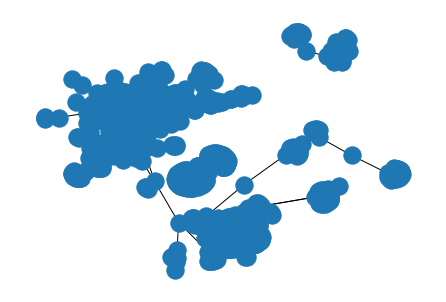

In [ ]:
c=0
for component in list(nx.connected_components(G)):
    c += 1
nx.draw(G)
print('number of nodes =',G.number_of_nodes(),', number of edges =', G.number_of_edges(),'. number of components =',c) 

In [59]:
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
print(len(S))

177


In [ ]:
for e in S:
    print(e)

Graph with 913 nodes and 965 edges
Graph with 381 nodes and 608 edges
Graph with 213 nodes and 213 edges
Graph with 40 nodes and 39 edges
Graph with 379 nodes and 454 edges


In [ ]:
for i,e in enumerate(S):
    print('component',i)
    print(list(e.nodes.data()))

component 0
[(1546828871018123264, {'category': 'war'}), (1570405136119349249, {'category': 'war'}), (1570864232937279488, {'category': 'war'}), (1552945698466938880, {'category': 'war'}), (1557094110590377985, {'category': 'war'}), (1374117517682221061, {'category': 'war'}), (788068200680423424, {'category': 'war'}), (1497612959291424769, {'category': 'war'}), (1277689617794445313, {'category': 'war'}), (1240266389090435072, {'category': 'war'}), (1453968648477888516, {'category': 'war'}), (1510679240324399106, {'category': 'war'}), (1522911176581160966, {'category': 'war'}), (1549685438742286343, {'category': 'war'}), (1371135963469123590, {'category': 'war'}), (1502394564585439239, {'category': 'war'}), (13572112, {'category': 'war'}), (1497703105516953609, {'category': 'war'}), (1498766831582076942, {'category': 'war'}), (1513211016884240397, {'category': 'war'}), (1499843905944231948, {'category': 'war'}), (1429094883252387853, {'category': 'war'}), (1375586471764185105, {'categor

component 1
[(1492968163662868480, {'category': 'war'}), (1494762660302573569, {'category': 'war'}), (1570855321563799552, {'category': 'war'}), (1530174841978077185, {'category': 'war'}), (1501281725900595201, {'category': 'war'}), (1499825748307234821, {'category': 'war'}), (1570515126536617984, {'category': 'war'}), (1570868908277596162, {'category': 'war'}), (1570548248275988483, {'category': 'war'}), (1566923265767088128, {'category': 'war'}), (1564737974105001986, {'category': 'war'}), (1564681765142265857, {'category': 'war'}), (1473417708536541192, {'category': 'war'}), (1474878193823801357, {'category': 'war'}), (1455936665814507534, {'category': 'war'}), (1492331870570356747, {'category': 'war'}), (1433101070339817488, {'category': 'war'}), (1516178254679445518, {'category': 'war'}), (1496887783364956169, {'category': 'war'}), (1370042653631512586, {'category': 'war'}), (1473671970919268364, {'category': 'war'}), (1566881850513031172, {'category': 'war'}), (150523457774854145

component 2
[(1056011072463925248, {'category': 'war'}), (1006081814849576960, {'category': 'war'}), (1533986303716773888, {'category': 'war'}), (1533863834884112384, {'category': 'war'}), (1356089369820504065, {'category': 'war'}), (1544901465638146049, {'category': 'war'}), (1519255684575121408, {'category': 'war'}), (1484971654061166597, {'category': 'war'}), (1480932386703613958, {'category': 'war'}), (1505161363093704709, {'category': 'war'}), (1464903300642447368, {'category': 'war'}), (1533191197317120003, {'category': 'war'}), (1420505782563622916, {'category': 'war'}), (1361377617748844551, {'category': 'war'}), (1358871320293998594, {'category': 'war'}), (1089999267912171526, {'category': 'war'}), (1328792234276364295, {'category': 'war'}), (1508389974231687179, {'category': 'war'}), (1492183283580420108, {'category': 'war'}), (1475643351240163341, {'category': 'war'}), (1523569315819274241, {'category': 'war'}), (1466049585785282572, {'category': 'war'}), (147200760675983360

component 3
[(1529147570454511616, {'category': 'war'}), (1518768257833963521, {'category': 'war'}), (2477973888, {'category': 'war'}), (1533113942008020992, {'category': 'war'}), (1446883966670225412, {'category': 'war'}), (1498374754176323589, {'category': 'war'}), (1344267977777152000, {'category': 'war'}), (1169793310241755137, {'category': 'war'}), (1418896937437253640, {'category': 'war'}), (1242889136647921666, {'category': 'war'}), (1517302028883660809, {'category': 'war'}), (47941897, {'category': 'war'}), (1447248997253406723, {'category': 'war'}), (1162764654164226049, {'category': 'war'}), (1440388738253684745, {'category': 'war'}), (1460180978802970625, {'category': 'war'}), (1449095497701003280, {'category': 'war'}), (878783588350795778, {'category': 'war'}), (470919829, {'category': 'war'}), (1429901320799010816, {'category': 'war'}), (1174810652, {'category': 'war'}), (328626719, {'category': 'war'}), (25924647, {'category': 'war'}), (120100776, {'category': 'war'}), (1